In [9]:
import numpy as np 
import pandas as pd
import os
import psycopg2
import geopandas as gpd

import importlib
from Secrets import secrets
# importlib.reload(secrets)

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
import statsmodels.formula.api as smf
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import time
from sklearn.cluster import KMeans

# Get Dataset 

In [130]:
# Get the summary of property and area characteristics, plus sold price
# However, the property price dataset is likely to include government schemes, shared owernship 
# Therefore exclude any property with very low sold price
# Assume the minimum property price is 200000
# Also filter out anything less than 15sqm or more than 300 as there may be mistake in epc data


engine = psycopg2.connect(database="postgres", user=secrets.user(), password=secrets.password(), host=secrets.host(), port='5432')
cur = engine.cursor()
cur.execute("""
SELECT 
    p.brn, p.year, p.lsoa, c.ward_name, e.number_habitable_rooms, 
    CASE WHEN p.type in ('S', 'T') THEN 'TS' ELSE p.type END as type, 
    p.duration, p.new, 
    e.construction_age_band, 
    CASE WHEN e.potential_energy_rating in ('A', 'B') THEN 'good' WHEN e.potential_energy_rating in ('C', 'D') THEN 'ok' ELSE 'bad' end as potential_energy_rating , 
    sum_cases, avg_no_of_res, 
    CASE WHEN num_of_stations > 0 THEN 1 ELSE 0 END as num_of_stations, 
    CASE WHEN num_of_stores > 0 THEN 1 ELSE 0 END as num_of_stores, 
    num_of_schools, 
    CASE WHEN num_of_top_schools >0 THEN 1 ELSE 0 END as num_of_top_schools,
    
    ROUND( ((CAST(potential_energy_efficiency as float) - CAST(current_energy_efficiency as float) )/CAST(potential_energy_efficiency as float))::numeric, 1) as diff,
    CAST(ROUND((p.price/e.total_floor_area)::numeric, 3 ) as integer) as sqm_price,
    e.total_floor_area,
    p.price
    
from prices as p
join epc as e
on e.brn = p.brn

join ( select c.year, c.lsoa, g.ward_name, sum(c.value) as sum_cases, avg(g.no_of_res) as avg_no_of_res
from crime_by_year as c
join geo2 as g
on g.lsoa = c.lsoa
where g.no_of_res != 0
group by 1, 2, 3) as c
on p.lsoa = c.lsoa and p.year = c.year

left join (select lsoa, count(station) as num_of_stations
from stations group by 1) as s
on s.lsoa = p.lsoa

left join (select lsoa, count(distinct name) as num_of_stores from stores group by 1) as st
on st.lsoa = p.lsoa


left join (select lsoa, count(distinct school_nam) as num_of_schools from schools2 group by 1) as sc
on sc.lsoa = p.lsoa

left join (select lsoa, count(distinct school_nam) as num_of_top_schools from schools2 where top_rated = 'Y' group by 1) as sc2
on sc2.lsoa = p.lsoa

where e.total_floor_area <> 0 and e.number_habitable_rooms is not null and e.total_floor_area is not null and e.potential_energy_efficiency <>0
and p.price > 200000
and e.total_floor_area > 15 and e.total_floor_area < 300
and CAST(ROUND((p.price/e.total_floor_area)::numeric, 3 ) as integer) > 1000 and CAST(ROUND((p.price/e.total_floor_area)::numeric, 3 ) as integer) < 16000
and e.number_habitable_rooms < 7
and p.type != 'O'
and e.construction_age_band != '0'
;

""")
rows = cur.fetchall()
result = pd.DataFrame(rows, columns = [desc[0] for desc in cur.description])
result = result.fillna(0)
result["diff"] = result["diff"].astype('float')
print(result.shape)
result.head()

(982235, 20)


brn    year       lsoa ward_name  number_habitable_rooms type  \
0  4.552979e+09  2008.0  E01000006     Abbey                     5.0   TS   
1  3.923376e+09  2009.0  E01000006     Abbey                     5.0   TS   
2  3.923376e+09  2009.0  E01000006     Abbey                     5.0   TS   
3  1.075111e+09  2009.0  E01000006     Abbey                     5.0   TS   
4  6.566426e+09  2009.0  E01000006     Abbey                     5.0   TS   

  duration new construction_age_band potential_energy_rating  sum_cases  \
0        F   N             1900-1929                    good      104.0   
1        F   N             1930-1949                    good       91.0   
2        F   N             1900-1929                     bad       91.0   
3        F   N             1900-1929                      ok       91.0   
4        F   N             1930-1949                      ok       91.0   

   avg_no_of_res  num_of_stations  num_of_stores  num_of_schools  \
0         1703.0                0              0            14.0   
1         1703.0                0              0            14.0   
2         1703.0                0              0            14.0   
3         1703.0                0              0            14.0   
4         1703.0                0              0            14.0   

   num_of_top_schools  diff  sqm_price  total_floor_area     price  
0                   0   0.3       2632             95.00  249995.0  
1                   0   0.3       2165             97.00  210000.0  
2                   0   0.3       2452             85.64  210000.0  
3                   0   0.3       1869            130.00  243000.0  
4                   0   0.3       2556             90.00  230000.0

# Segment the areas based on type of Food/Bars there are


In [4]:
# Extract a few of the moost popular food venue categories
# Look at venue count per resident?
#
engine = psycopg2.connect(database="postgres", user=secrets.user(), password=secrets.password(), host=secrets.host(), port='5432')
cur = engine.cursor()
cur.execute("""
SELECT 
    lsoa,
    sum(CASE WHEN l3 in ('Café', 'Coffee Shop') THEN 1 else 0 end) as count_coffee_shop,
    sum(CASE WHEN l3 in ('Pub') THEN 1 else 0 end) as count_pub,
    sum(CASE WHEN l3 in ('Bar') THEN 1 else 0 end) as count_bar,
    sum(CASE WHEN l3 in ('Cocktail Bar') THEN 1 else 0 end) as count_cocktail,
    sum(CASE WHEN l3 in ('French Restaurant', 'Japanese Restaurant') THEN 1 else 0 end) as count_french_japan,
    sum(CASE WHEN l3 in ('Indian Restaurant', 'Chinese Restaurant') THEN 1 else 0 end) as count_asian 
    
    from food
    group by 1
;

""")
rows = cur.fetchall()
df_food = pd.DataFrame(rows, columns = [desc[0] for desc in cur.description])
print(df_food.shape)
df_food.dropna(inplace=True)
df_food.head()

(4833, 7)


lsoa  count_coffee_shop  count_pub  count_bar  count_cocktail  \
0  E01002168                  3          2          1               1   
1  E01002671                 13          9          1               0   
2  E01001262                  4          2          1               1   
3  E01001641                 10         14          0               0   
4  E01004374                 13          5          2               0   

   count_french_japan  count_asian  
0                   0           16  
1                   5            5  
2                   0            9  
3                   4            1  
4                   0            4

In [5]:
# Normalize the data
df_food_norm = df_food[df_food.columns[1:]].div(df_food[df_food.columns[1:]].sum(axis=1), axis=0)
df_food_norm.fillna(0, inplace=True)

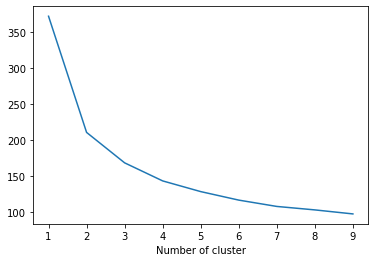

In [221]:
# Use elbow method to find an optimal number of K
from sklearn.cluster import KMeans

sse={}
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(df_food_norm)
    df_food_norm["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

In [10]:
# Looks like there are about 3 clusters
kmeans = KMeans(n_clusters=3, max_iter=1000).fit(df_food_norm)
df_food_norm["clusters"] = kmeans.labels_
df_food_norm["lsoa"] = df_food["lsoa"]

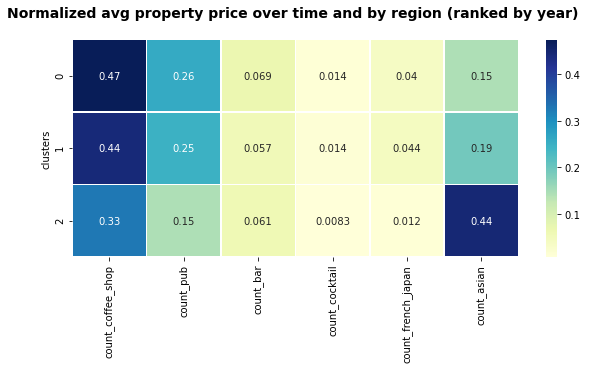

In [235]:
# examine clusters
fig, ax = plt.subplots(figsize=(10, 4))
sns.heatmap(df_food_norm.groupby("clusters").mean(), annot=True, linewidths=.5, ax=ax, cmap="YlGnBu")
ax.set_title("Normalized avg property price over time and by region (ranked by year) \n", fontweight='bold', fontsize=14)
plt.show()

In [ ]:
# Unnormalized version

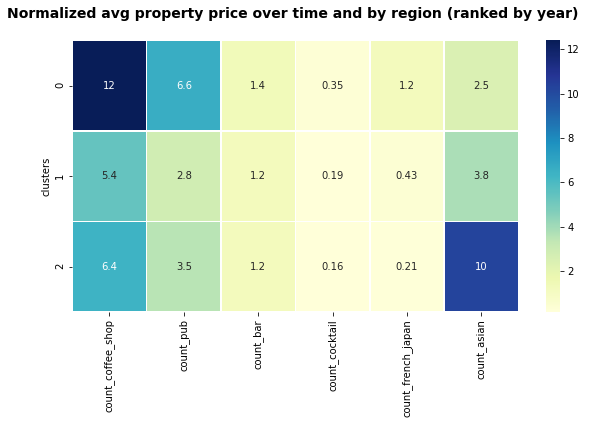

In [233]:
# Use elbow method to find an optimal number of K
from sklearn.cluster import KMeans
df = df_food[df_food.columns[1:]]
# Looks like there are about 4 clusters
kmeans = KMeans(n_clusters=3, max_iter=1000).fit(df)
df["clusters"] = kmeans.labels_
df["lsoa"] = df_food["lsoa"]

fig, ax = plt.subplots(figsize=(10, 4))
sns.heatmap(df.groupby("clusters").mean(), annot=True, linewidths=.5, ax=ax, cmap="YlGnBu")
ax.set_title("Normalized avg property price over time and by region (ranked by year) \n", fontweight='bold', fontsize=14)
plt.show()

In [264]:
# Quick check back to the price per sqm
df_temp = result.merge(df_food_norm, how="right", on="lsoa")[["clusters", "sqm_price", "total_floor_area", "price"]]
df_temp.groupby("clusters").agg({"sqm_price": ["mean", "std", "min", "max"], "total_floor_area": ["mean", "std", "min", "max"], "price": "mean"})

sqm_price                               total_floor_area  \
                 mean          std     min      max             mean   
clusters                                                               
0         5822.466140  2478.704076  1016.0  15999.0        88.999578   
1         6161.027809  2949.308769  1005.0  15998.0        89.694073   
2         4441.911969  1541.094828  1009.0  15952.0        93.432146   

                                           price  
                std    min    max           mean  
clusters                                          
0         45.264031  15.37  896.0  507969.693346  
1         47.086092  15.25  899.0  541555.210110  
2         39.441031  15.10  784.0  402372.059369

In [ ]:
# Interesting observation:
# Cluster 1 tend to have more coffee shops less indian/chinese restaurants, more pubs and bars, coctail places
# Cluster 2 tend to have more a bit of all venues
# Cluster 3 tend to have more indian/chinese restaurants than other clusters
# From the price perspective:
# Cluster 2 has the lowest price indicating that potentially indian/chinese restaurants are located in outskirts in more affordable areas and larger houses
# Cluster 0 is more expensive than cluster 2 potentially driven by more venues to go out
# Cluster 1 is the most expensive potentially a high end suburbs area

In [107]:
engine = psycopg2.connect(database="postgres", user=secrets.user(), password=secrets.password(), host=secrets.host(), port='5432')

sql = """
select
    lsoa, rg_name, lsoa_geometry from geo2
"""

gdf_new = gpd.read_postgis(sql, engine, geom_col='lsoa_geometry') 
gdf_new.head(2)

lsoa               rg_name  \
0  E01000001        City of London   
1  E01000007  Barking and Dagenham   

                                       lsoa_geometry  
0  POLYGON ((532105.092 182011.230, 532162.491 18...  
1  POLYGON ((544180.347 184700.582, 544317.196 18...

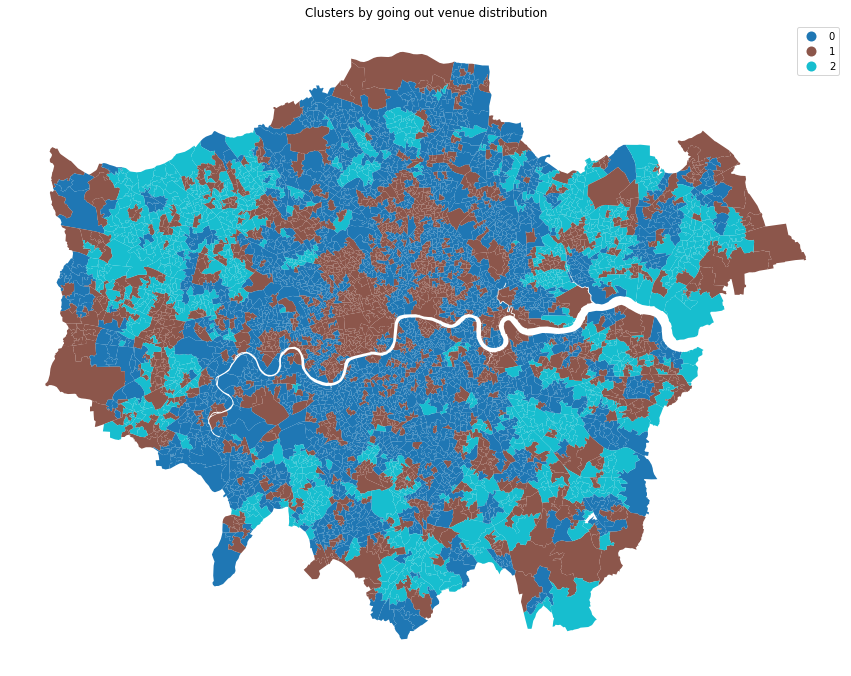

In [326]:
fig, ax = plt.subplots(figsize=(15, 15))
ax.axis('off')
temp = gdf_new.merge(df_food_norm, how="right", on="lsoa")
temp["clusters"] = temp["clusters"].astype("str")
temp.plot(ax = ax, column="clusters",legend=True)
ax.set_title("Clusters by going out venue distribution")
plt.show()

# This shows a great result
# Cluster 1 (the most expensive) is focused on central parts of each borough
# Cluster 0 the 2nd most expensive is surrunding the borough centers
# Cluster 2 is more remote to any central part of any borough

#  Segment areas based on the price distribution

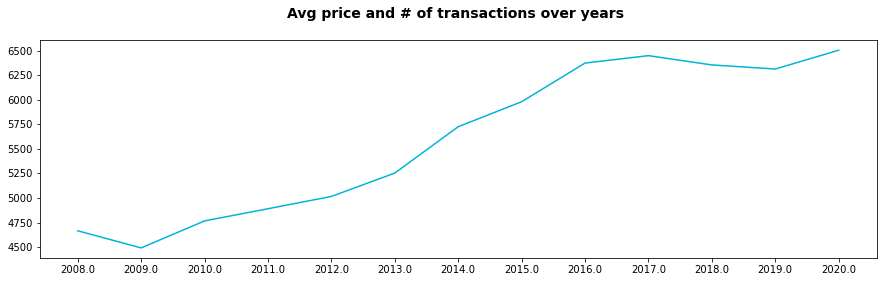

In [276]:
# Agree on the period
# If we want to forecast the current property price (say for the next 6 months) we can use the current year prices as a base
# Train period is 2017-2019-2020 (as per below) average price per sqm is marginanly unchanged during those years

fig, ax = plt.subplots(figsize=(15, 4))
labels = result.groupby("year", as_index=False)["sqm_price"].mean()["year"].values
ax.set_title("Avg price and # of transactions over years \n", fontweight='bold', fontsize=14)
ax.plot(result.groupby("year", as_index=False)["sqm_price"].mean()["sqm_price"], color="#00b4d8")
ax.set_xticks(np.arange(len(labels)))
ax.set_xticklabels(labels)

plt.show()

In [294]:
df_subset.groupby("lsoa", as_index=False).agg( {"sqm_price": ["mean", "std"]})

lsoa    sqm_price             
                        mean          std
0     E01000006  4229.636364   789.321705
1     E01000007  4375.333333   608.636292
2     E01000008  3596.208333   560.209121
3     E01000009  3834.640000   756.711739
4     E01000010  5139.470000  1158.742243
...         ...          ...          ...
4823  E01033742  4805.200000   618.992114
4824  E01033743  4200.571429   718.537273
4825  E01033744  5012.683333   807.205947
4826  E01033745  4243.266667   686.073694
4827  E01033746  8741.477477  1889.605865

[4828 rows x 3 columns]

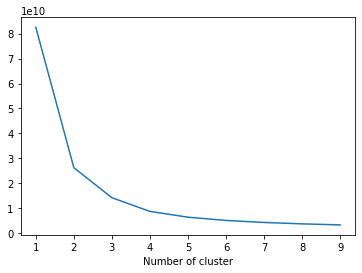

In [100]:
df_subset = result[result.year > 2016]
def percentil25 (x): 
    return np.percentile(x, q=25)

def percentil75 (x): 
    return np.percentile(x, q=75)

df_subset = result[result.year > 2016]
df_subset = df_subset.groupby("lsoa", as_index=False).agg( {"sqm_price": ["mean", "std", "median",  percentil25, percentil75]})
df_subset.columns =["lsoa", "mean", "std", "median", "q25", "q75"]

df_subset.fillna(df_subset["std"].mean(), inplace=True)
# Use elbow method to find an optimal number of K
from sklearn.cluster import KMeans

df_temp = df_subset[df_subset.columns[1:]]
sse={}
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(df_temp)
    df_temp["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

In [104]:
# Looks like there are about 3 clusters
df_subset = result[result.year > 2016]
def percentil25 (x): 
    return np.percentile(x, q=25)

def percentil75 (x): 
    return np.percentile(x, q=75)

df_subset = result[result.year > 2016]
df_subset = df_subset.groupby("lsoa", as_index=False).agg( {"sqm_price": ["mean", "std", "median",  percentil25, percentil75]})
df_subset.columns =["lsoa", "mean", "std", "median", "q25", "q75"]
df_subset.fillna(df_subset["std"].mean(), inplace=True)
df_temp = df_subset[df_subset.columns[1:]]
kmeans = KMeans(n_clusters=3, max_iter=1000).fit(df_temp)
df_temp["clusters"] = kmeans.labels_
df_temp["lsoa"] = df_subset["lsoa"]

In [99]:
df_temp.groupby("clusters").agg({"lsoa": "count", "mean":"mean", "std":"mean", "median": "mean", "q25": "mean", "q75": "mean"}).rename({"lsoa": "no_of_lsoa"})

lsoa          mean          std        median          q25  \
clusters                                                               
0         2767   5042.234692  1097.302405   4949.801229  4388.159017   
1          593  10424.343753  2407.541632  10492.870152  8968.686341   
2         1468   7387.284822  1765.964275   7220.446526  6280.337704   

                   q75  
clusters                
0          5554.530087  
1         12001.713744  
2          8313.855075

In [319]:
# This is very insightful
# Cluster 0 > has mohast lsoa areas, lowest mean price per sqm of 5k, lowest std of mean price
# Cluster 1 > has less lsoa areas, much higher average price per sqm, higher std
# Cluster 3 > lsoa with the most expensive property, and the most variance in mean price
# All clusters include lsoa areas with average of 60 sold property so the view is balanced
# There seem to be a negative relationship between price per sqm and variance of the price
# The more expensive is the area the more variation in the price

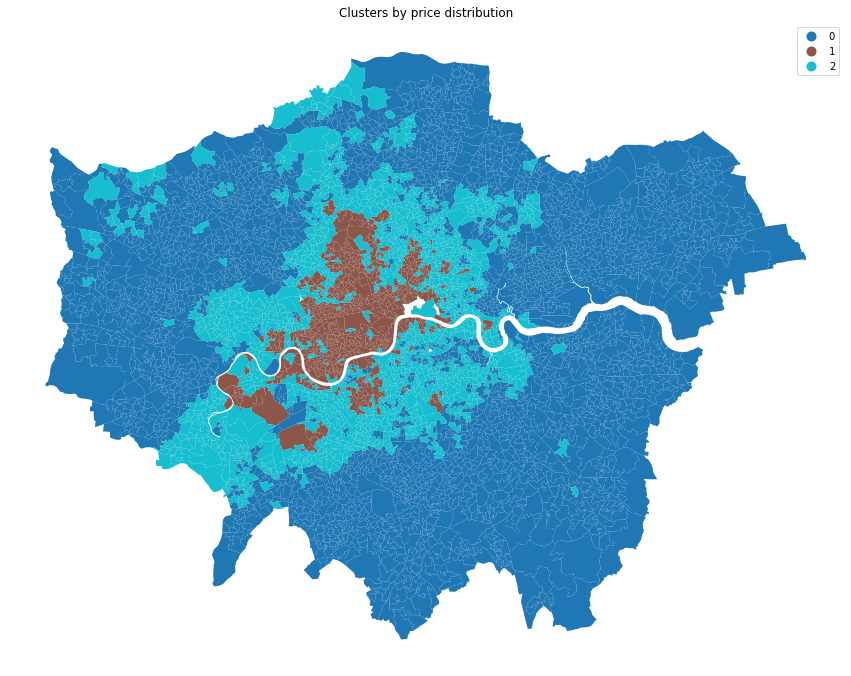

In [108]:
ig, ax = plt.subplots(figsize=(15, 15))
ax.axis('off')
temp = gdf_new.merge(df_temp, how="right", on="lsoa")
temp["clusters"] = temp["clusters"].astype("str")
temp.plot(ax = ax, column="clusters",legend=True)
ax.set_title("Clusters by price distribution")
plt.show()

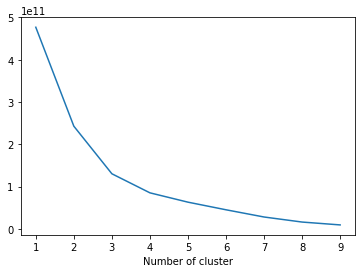

In [160]:
# Cluster construction age band in less buckets
temp_const_band = pd.pivot_table(result[result.year > 2016][["construction_age_band", "lsoa", "sqm_price"]], index="construction_age_band", columns="lsoa").fillna(0)

from sklearn.manifold import MDS

embedding = MDS(n_components=2)
temp_const_band_transformed = embedding.fit_transform(temp_const_band)
temp_const_band_transformed = pd.DataFrame(np.concatenate([temp_const_band.index.values[:, np.newaxis],\
                                                           temp_const_band_transformed], axis=1), columns=["construction_age_band", "PCA1", "PCA2"])


df_cons_bands = temp_const_band_transformed[["PCA1", "PCA2"]]
sse={}
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(df_cons_bands)
    df_cons_bands["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

In [161]:
kmeans = KMeans(n_clusters=3, max_iter=1000).fit(df_cons_bands)
df_cons_bands["clusters"] = kmeans.labels_
df_cons_bands["construction_age_band"] = temp_const_band_transformed["construction_age_band"]

In [166]:
my_dict = {}
for i in df_cons_bands[["clusters", "construction_age_band"]].iterrows():
    my_dict[i[1]["construction_age_band"]] = i[1]["clusters"]

# Combine dataset for predictive model

In [168]:
df = result[result.year > 2017][['lsoa', 'number_habitable_rooms', 'type',
       'duration', 'new', 'construction_age_band', 'potential_energy_rating',
       'sum_cases', 'avg_no_of_res', 'num_of_stations', 'num_of_stores',
       'num_of_schools', 'num_of_top_schools', 'diff', 'sqm_price',
       'total_floor_area']]

# add venue clusters
df = df.merge(df_food_norm[["clusters", "lsoa"]].rename(columns = {"clusters": "venue_clusters"}), on="lsoa")

# add price clusters (use instead of area)
df = df.merge(df_temp[["clusters", "lsoa"]].rename(columns = { "clusters": "price_clusters"}), on="lsoa")

# map construction_age_band
df["construction_age_band"] = df["construction_age_band"].map(my_dict)


# drop lsoa
# df.drop("lsoa", axis=1, inplace=True)
# Random Forest + mean encoding
# Cluster areas based on price etc


# Mean Encoding (Average from the entire dataset)

In [171]:
# df['type'] = df.groupby(['type', 'price_clusters'])['sqm_price'].transform('mean')
# df['duration'] = df.groupby(['duration', 'price_clusters'])['sqm_price'].transform('mean')
# df['new'] = df.groupby(['new', 'price_clusters'])['sqm_price'].transform('mean')
# df['construction_age_band'] = df.groupby(['construction_age_band', 'price_clusters'])['sqm_price'].transform('mean')
# df['potential_energy_rating'] = df.groupby(['potential_energy_rating', 'price_clusters'])['sqm_price'].transform('mean')


# Encode categorical variables with the mean target value of that category for corresponding lsoa area (as we know that the 
# price of property is highly dependent on the area)
df['type'] = df.groupby(['type', 'lsoa'])['sqm_price'].transform('mean')
df['duration'] = df.groupby(['duration', 'lsoa'])['sqm_price'].transform('mean')
df['new'] = df.groupby(['new', 'lsoa'])['sqm_price'].transform('mean')
df['construction_age_band'] = df.groupby(['construction_age_band', 'lsoa'])['sqm_price'].transform('mean')
df['potential_energy_rating'] = df.groupby(['potential_energy_rating', 'lsoa'])['sqm_price'].transform('mean')
df['lsoa'] = df.groupby(['lsoa'])['sqm_price'].transform('mean')

In [172]:
df

lsoa  number_habitable_rooms         type     duration  \
0       4233.589744                     5.0  4151.392857  4151.392857   
1       4233.589744                     5.0  4151.392857  4151.392857   
2       4233.589744                     3.0  4442.818182  4442.818182   
3       4233.589744                     3.0  4442.818182  4442.818182   
4       4233.589744                     4.0  4151.392857  4151.392857   
...             ...                     ...          ...          ...   
196982  8653.328358                     5.0  9398.395349  9284.348837   
196983  8653.328358                     6.0  9398.395349  9284.348837   
196984  8653.328358                     5.0  9398.395349  9284.348837   
196985  8653.328358                     4.0  7451.434783  7522.750000   
196986  8653.328358                     3.0  7451.434783  7522.750000   

                new  construction_age_band  potential_energy_rating  \
0       4233.589744            4151.392857              4219.263158   
1       4233.589744            4151.392857              4219.263158   
2       4233.589744            4448.250000              4185.421053   
3       4233.589744            4428.333333              4219.263158   
4       4233.589744            4151.392857              4219.263158   
...             ...                    ...                      ...   
196982  8653.328358            8863.819672              8441.657143   
196983  8653.328358            8863.819672              8974.148148   
196984  8653.328358            8863.819672              8974.148148   
196985  8653.328358            8863.819672              8441.657143   
196986  8653.328358            8863.819672              8441.657143   

        sum_cases  avg_no_of_res  num_of_stations  num_of_stores  \
0           123.0         1703.0                0              0   
1           123.0         1703.0                0              0   
2           123.0         1703.0                0              0   
3           123.0         1703.0                0              0   
4           123.0         1703.0                0              0   
...           ...            ...              ...            ...   
196982       61.0         1464.0                0              0   
196983       61.0         1464.0                0              0   
196984       61.0         1464.0                0              0   
196985       61.0         1464.0                0              0   
196986       61.0         1464.0                0              0   

        num_of_schools  num_of_top_schools  diff  sqm_price  total_floor_area  \
0                 14.0                   0   0.3       2222            108.00   
1                 14.0                   0   0.0       2394            100.25   
2                 14.0                   0   0.1       3361             61.00   
3                 14.0                   0   0.0       3868             53.00   
4                 14.0                   0   0.2       4450            100.00   
...                ...                 ...   ...        ...               ...   
196982             5.0                   0   0.4       8333            114.00   
196983             5.0                   0   0.3       6748            163.00   
196984             5.0                   0   0.4       7889             90.00   
196985             5.0                   0   0.3       7403             77.00   
196986             5.0                   0   0.2       8024             71.04   

        venue_clusters  price_clusters  
0                    0               0  
1                    0               0  
2                    0               0  
3                    0               0  
4                    0               0  
...                ...             ...  
196982               2               2  
196983               2               2  
196984               2               2  
196985               2               2  
196986               2               2  

[1

In [71]:
# Split to features and target
X = df.drop("sqm_price", axis=1)
y = df["sqm_price"]

In [173]:

# Run Regression on a random sample as otherwise the dataset is too large
# df_sample = result.sample(n=1000000, replace=False, random_state=5)

# Run reg on all feature
reg_x = " + ".join(X.columns)

# Fit regression model (using the natural log of one of the regressors)
reg_result = smf.ols(f'sqm_price ~ {reg_x}', data=df).fit()

# Inspect the results
print(reg_result.summary())

                            OLS Regression Results                            
Dep. Variable:              sqm_price   R-squared:                       0.721
Model:                            OLS   Adj. R-squared:                  0.721
Method:                 Least Squares   F-statistic:                 2.997e+04
Date:                Sun, 31 Jan 2021   Prob (F-statistic):               0.00
Time:                        16:16:05   Log-Likelihood:            -1.6854e+06
No. Observations:              196987   AIC:                         3.371e+06
Df Residuals:                  196969   BIC:                         3.371e+06
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                1

In [ ]:
# All features are found to be statistically significant, however R2 is only 57% which may indicate that the relationship is not linear

In [73]:
X["sum_cases"] = np.log(X["sum_cases"])
X = X.replace([np.inf, -np.inf], np.nan).fillna(0)

/home/elena/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [364]:
# Random Forest
# 1st try to remove less useful features to improve speed 


In [174]:
# Split to features and target
X = df.drop("sqm_price", axis=1)
y = df["sqm_price"]

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.20, random_state=42)

regr = RandomForestRegressor(n_estimators = 100, min_samples_split = 3, max_depth = 30, random_state=0)
regr.fit(X_train, y_train)
df_features = pd.DataFrame(np.stack([X.columns.values, regr.feature_importances_], axis=1), columns=["Feature", "Rank"]).sort_values(by="Rank", ascending=False)
train_score = regr.score(X_train, y_train)
test_score = regr.score(X_test, y_test)

predictions_train = pd.DataFrame(regr.predict(X_train)).rename(columns={0: "prediction"})
predictions_train["Actual"] = pd.DataFrame(y_train).reset_index().drop("index", axis=1)

predictions_test = pd.DataFrame(regr.predict(X_test)).rename(columns={0: "prediction"})
predictions_test["Actual"] = pd.DataFrame(y_test).reset_index().drop("index", axis=1)

mse_train = np.sqrt(np.power((predictions_train["Actual"] - predictions_train["prediction"]), 2).sum()/predictions_train.shape[0])
mse_test = np.sqrt(np.power((predictions_test["Actual"] - predictions_test["prediction"]), 2).sum()/predictions_test.shape[0])

print("test ", test_score)
print("train ", train_score)

print("mse_train ", mse_train)
print("mse_test ", mse_test)


test  0.7502881551389897
train  0.9571000802820847
mse_train  493.9096798762052
mse_test  1183.3001761277312


In [35]:
predictions["diff"] = predictions["Actual"] - predictions["prediction"]
predictions["diff_perc"] = predictions["diff"]/predictions["Actual"]

In [77]:
df_features

Feature         Rank
5     construction_age_band      0.69085
14         total_floor_area    0.0792119
2                      type    0.0536331
6   potential_energy_rating    0.0341332
7                 sum_cases    0.0295102
3                  duration    0.0182118
8             avg_no_of_res    0.0161863
13                     diff    0.0154467
1    number_habitable_rooms    0.0153581
0                      lsoa    0.0150266
4                       new    0.0129198
11           num_of_schools    0.0124667
15           venue_clusters   0.00288385
12       num_of_top_schools   0.00168996
10            num_of_stores   0.00156298
16           price_clusters  0.000462706
9           num_of_stations  0.000445972

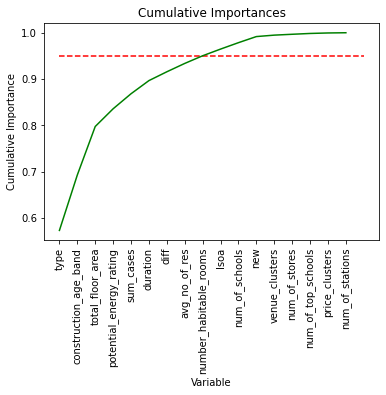

In [175]:
# List of features sorted from most to least important
sorted_importances = [x for x in df_features.Rank]
sorted_features = [x for x in df_features.Feature]
x_values = list(range(len(regr.feature_importances_)))
# Cumulative importances
cumulative_importances = np.cumsum(sorted_importances)
# Make a line graph
plt.plot(x_values, cumulative_importances, 'g-')
# Draw line at 95% of importance retained
plt.hlines(y = 0.95, xmin=0, xmax=len(sorted_importances), color = 'r', linestyles = 'dashed')
# Format x ticks and labels
plt.xticks(x_values, sorted_features, rotation = 'vertical')
# Axis labels and title
plt.xlabel('Variable'); plt.ylabel('Cumulative Importance'); plt.title('Cumulative Importances');

In [83]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [200, 300, 400, 500, 600]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [10, 20, 30, 40, 50, 60, 70]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [200, 300, 400, 500, 600], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [2, 4], 'bootstrap': [True, False]}


In [85]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 50, cv = 3, verbose=2, random_state=42, n_jobs = None)
# Fit the random search model
rf_random.fit(X_train, y_train)

print(rf_random.best_params_)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
/home/elena/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed: 21.6min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed: 236.3min finished


{'n_estimators': 500, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 40, 'bootstrap': True}


In [176]:
# {'n_estimators': 500, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 40, 'bootstrap': True}

regr = RandomForestRegressor(n_estimators= 500, min_samples_split= 5, min_samples_leaf= 2, max_features= 'sqrt', max_depth= 40, bootstrap= True, random_state=0)
regr.fit(X_train, y_train)
df_features = pd.DataFrame(np.stack([X.columns.values, regr.feature_importances_], axis=1), columns=["Feature", "Rank"]).sort_values(by="Rank", ascending=False)
train_score = regr.score(X_train, y_train)
test_score = regr.score(X_test, y_test)

predictions_train = pd.DataFrame(regr.predict(X_train)).rename(columns={0: "prediction"})
predictions_train["Actual"] = pd.DataFrame(y_train).reset_index().drop("index", axis=1)

predictions_test = pd.DataFrame(regr.predict(X_test)).rename(columns={0: "prediction"})
predictions_test["Actual"] = pd.DataFrame(y_test).reset_index().drop("index", axis=1)

mse_train = np.sqrt(np.power((predictions_train["Actual"] - predictions_train["prediction"]), 2).sum()/predictions_train.shape[0])
mse_test = np.sqrt(np.power((predictions_test["Actual"] - predictions_test["prediction"]), 2).sum()/predictions_test.shape[0])

print("test ", test_score)
print("train ", train_score)

print("mse_train ", mse_train)
print("mse_test ", mse_test)

test  0.7550253056809423
train  0.9039330852113292
mse_train  739.1051352824032
mse_test  1172.022555582223


In [177]:
df_features

Feature         Rank
2                      type     0.205914
5     construction_age_band     0.174164
3                  duration     0.139345
6   potential_energy_rating     0.128676
14         total_floor_area    0.0867849
4                       new    0.0768615
0                      lsoa    0.0689806
16           price_clusters     0.026591
7                 sum_cases    0.0228696
1    number_habitable_rooms    0.0160157
13                     diff    0.0143729
8             avg_no_of_res    0.0139485
11           num_of_schools    0.0114881
10            num_of_stores   0.00741059
15           venue_clusters   0.00451167
12       num_of_top_schools    0.0016678
9           num_of_stations  0.000398052

In [ ]:
# my_dict = {"n_est": [], "n_depth": [], "min_samples_split": [], "train_score": [], "test_score": [], "mse_train": [], "mse_test": [], "time_taken": []}

# X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.33, random_state=42)

# n_est = [100, 200, 300, 400]
# n_depth = [25, 30, 35, 40]
# min_samples_split = [3, 5, 6]
# for i in n_est:
#     for j in n_depth:
#         for k in min_samples_split:
#             print(i, j, k)
#             # Start the clock to capture how long the model takes to run
#             start_time = time.time()

#             regr = RandomForestRegressor(n_estimators = i, max_depth=j, min_samples_split=k, random_state=0)
#             regr.fit(X_train, y_train)
#             train_score = regr.score(X_train, y_train)
#             test_score = regr.score(X_test, y_test)

#             time_taken = (time.time() - start_time)/60
            
#             predictions_train = pd.DataFrame(regr.predict(X_train)).rename(columns={0: "prediction"})
#             predictions_train["Actual"] = pd.DataFrame(y_train).reset_index().drop("index", axis=1)

#             predictions_test = pd.DataFrame(regr.predict(X_test)).rename(columns={0: "prediction"})
#             predictions_test["Actual"] = pd.DataFrame(y_test).reset_index().drop("index", axis=1)

#             mse_train = np.sqrt(np.power((predictions_train["Actual"] - predictions_train["prediction"]), 2).sum()/predictions_train.shape[0])
#             mse_test = np.sqrt(np.power((predictions_test["Actual"] - predictions_test["prediction"]), 2).sum()/predictions_test.shape[0])

#             # Collect stats
#             my_dict["n_est"].append(i)
#             my_dict["n_depth"].append(j)
#             my_dict["train_score"].append(train_score)
#             my_dict["test_score"].append(test_score)
#             my_dict["time_taken"].append(time_taken)
#             my_dict["min_samples_split"].append(k)
#             my_dict["mse_train"].append(mse_train)
#             my_dict["mse_test"].append(mse_test)

# forest_results = pd.DataFrame(my_dict) 

In [ ]:
# forest_results

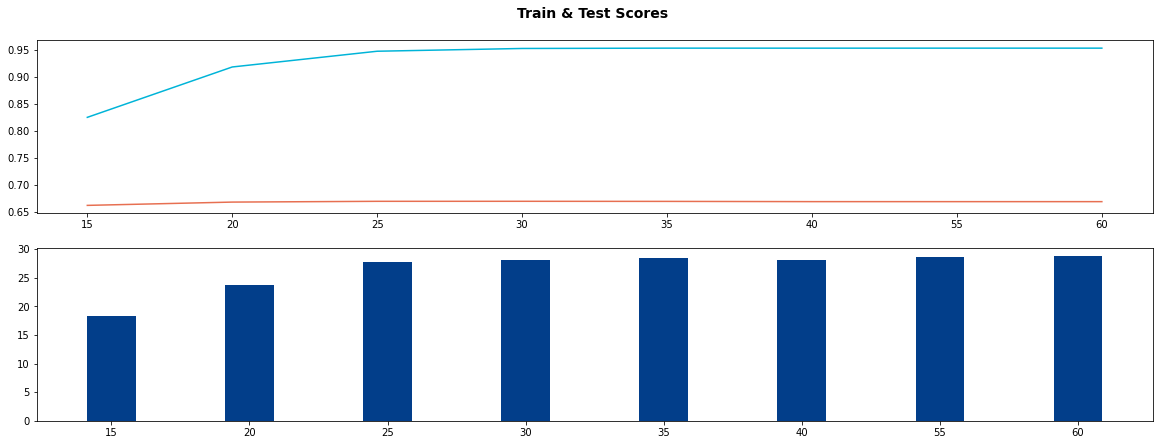

In [391]:
fig, ax = plt.subplots(ncols =1, nrows = 2, figsize=(20, 7))

ax[0].set_title("Train & Test Scores \n", fontweight='bold', fontsize=14)
ax[0].plot(forest_results["train_score"], color="#00b4d8")
ax[0].plot(forest_results["test_score"], color="#e76f51")

width = 0.35
labels = forest_results["n_depth"].values
x = np.arange(len(labels))
y = forest_results["time_taken"].values
ax[1].bar(x, y, width, color="#023e8a")
ax[1].set_xticks(x)
ax[0].set_xticks(x)
ax[1].set_xticklabels(labels)
ax[0].set_xticklabels(labels)


plt.show()

# Final model

In [57]:
# Excl features: num_of_top_schools, num_of_stores, num_of_stations
df = result[result.year > 2018][['lsoa', 'number_habitable_rooms', 'type',
       'duration', 'new', 'construction_age_band', 'potential_energy_rating',
       'sum_cases', 'avg_no_of_res',
       'num_of_schools', 'diff', 'sqm_price',
       'total_floor_area']]

# add venue clusters
df = df.merge(df_food_norm[["clusters", "lsoa"]].rename(columns = {"clusters": "venue_clusters"}), on="lsoa")

# add price clusters (use instead of area)
df = df.merge(df_temp[["clusters", "lsoa"]].rename(columns = { "clusters": "price_clusters"}), on="lsoa")

# drop lsoa
df.drop("lsoa", axis=1, inplace=True)

df['type'] = df.groupby(['type', 'price_clusters'])['sqm_price'].transform('mean')
df['duration'] = df.groupby(['duration', 'price_clusters'])['sqm_price'].transform('mean')
df['new'] = df.groupby(['new', 'price_clusters'])['sqm_price'].transform('mean')
df['construction_age_band'] = df.groupby(['construction_age_band', 'price_clusters'])['sqm_price'].transform('mean')
df['potential_energy_rating'] = df.groupby(['potential_energy_rating', 'price_clusters'])['sqm_price'].transform('mean')


# Split to features and target
X = df.drop("sqm_price", axis=1)
y = df["sqm_price"]


X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.30, random_state=42)

regr = RandomForestRegressor(n_estimators = 600, min_samples_split = 3, max_depth = 20, random_state=0)
regr.fit(X_train, y_train)
df_features = pd.DataFrame(np.stack([X.columns.values, regr.feature_importances_], axis=1), columns=["Feature", "Rank"]).sort_values(by="Rank", ascending=False)
train_score = regr.score(X_train, y_train)
test_score = regr.score(X_test, y_test)

predictions_train = pd.DataFrame(regr.predict(X_train)).rename(columns={0: "prediction"})
predictions_train["Actual"] = pd.DataFrame(y_train).reset_index().drop("index", axis=1)

predictions_test = pd.DataFrame(regr.predict(X_test)).rename(columns={0: "prediction"})
predictions_test["Actual"] = pd.DataFrame(y_test).reset_index().drop("index", axis=1)

mse_train = np.sqrt(np.power((predictions_train["Actual"] - predictions_train["prediction"]), 2).sum()/predictions_train.shape[0])
mse_test = np.sqrt(np.power((predictions_test["Actual"] - predictions_test["prediction"]), 2).sum()/predictions_test.shape[0])
            


print("test ", test_score)
print("train ", train_score)
print("mse_train ", mse_train)
print("mse_test ", mse_test)


test  0.6905539767380713
train  0.9111912011952208
mse_train  723.0006232354381
mse_test  1351.265762196554


In [55]:
regr = RandomForestRegressor(n_estimators = 600, min_samples_split = 6, random_state=0)
regr.fit(X_train, y_train)
df_features = pd.DataFrame(np.stack([X.columns.values, regr.feature_importances_], axis=1), columns=["Feature", "Rank"]).sort_values(by="Rank", ascending=False)
train_score = regr.score(X_train, y_train)
test_score = regr.score(X_test, y_test)

predictions_train = pd.DataFrame(regr.predict(X_train)).rename(columns={0: "prediction"})
predictions_train["Actual"] = pd.DataFrame(y_train).reset_index().drop("index", axis=1)

predictions_test = pd.DataFrame(regr.predict(X_test)).rename(columns={0: "prediction"})
predictions_test["Actual"] = pd.DataFrame(y_test).reset_index().drop("index", axis=1)

mse_train = np.sqrt(np.power((predictions_train["Actual"] - predictions_train["prediction"]), 2).sum()/predictions_train.shape[0])
mse_test = np.sqrt(np.power((predictions_test["Actual"] - predictions_test["prediction"]), 2).sum()/predictions_test.shape[0])
            


print("test ", test_score)
print("train ", train_score)
print("mse_train ", mse_train)
print("mse_test ", mse_test)

test  0.6923551105492263
train  0.9247157712447636
mse_train  663.4208264873166
mse_test  1336.8673307981446


# Analyze the results

In [ ]:
# Plot with errors by features with search box for post code